In [2]:
from time import time
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

# Load the data
file_path = '../../archive/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(file_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [6]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = df['text'].tolist()
Y = df['target'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
    if y == 4:
        data.append((tk.tokenize(x), 1))
    else:
        data.append((tk.tokenize(x), 0))
        
# Printing the CPU time and the first 5 elements of our 'data' list
print('CPU Time:', time() - start_time)
data[:5]

CPU Time: 81.88891172409058


[(['@switchfoot',
   'http://twitpic.com/2y1zl',
   '-',
   'Awww',
   ',',
   "that's",
   'a',
   'bummer',
   '.',
   'You',
   'shoulda',
   'got',
   'David',
   'Carr',
   'of',
   'Third',
   'Day',
   'to',
   'do',
   'it',
   '.',
   ';D'],
  0),
 (['is',
   'upset',
   'that',
   'he',
   "can't",
   'update',
   'his',
   'Facebook',
   'by',
   'texting',
   'it',
   '...',
   'and',
   'might',
   'cry',
   'as',
   'a',
   'result',
   'School',
   'today',
   'also',
   '.',
   'Blah',
   '!'],
  0),
 (['@Kenichan',
   'I',
   'dived',
   'many',
   'times',
   'for',
   'the',
   'ball',
   '.',
   'Managed',
   'to',
   'save',
   '50',
   '%',
   'The',
   'rest',
   'go',
   'out',
   'of',
   'bounds'],
  0),
 (['my',
   'whole',
   'body',
   'feels',
   'itchy',
   'and',
   'like',
   'its',
   'on',
   'fire'],
  0),
 (['@nationwideclass',
   'no',
   ',',
   "it's",
   'not',
   'behaving',
   'at',
   'all',
   '.',
   "i'm",
   'mad',
   '.',
   'why',
   'a

In [9]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kwfen\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [10]:
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        # First, we will convert the pos_tag output tags to a tag format that the WordNetLemmatizer can interpret
        # In general, if a tag starts with NN, the word is a noun and if it stars with VB, the word is a verb.
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

# Previewing the WordNetLemmatizer() output
print(lemmatize_sentence(data[0][0]))

['@switchfoot', 'http://twitpic.com/2y1zl', '-', 'Awww', ',', "that's", 'a', 'bummer', '.', 'You', 'shoulda', 'get', 'David', 'Carr', 'of', 'Third', 'Day', 'to', 'do', 'it', '.', ';D']


In [11]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words. Including many minimally present cases would negatively impact the performance. 
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
        return ''
    return token

# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        cleaned_token = cleaned(token.lower())
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if cleaned_token not in string.punctuation and len(cleaned_token) > 2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

# Prevewing the remove_noise() output
print(remove_noise(data[0][0]))

['awww', "that's", 'bummer', 'shoulda', 'get', 'david', 'carr', 'third', 'day']


In [12]:
start_time = time()

# As the Naive Bayesian classifier accepts inputs in a dict-like structure,
# we have to define a function that transforms our data into the required input structure
def list_to_dict(cleaned_tokens):
    return dict([token, True] for token in cleaned_tokens)

cleaned_tokens_list = []

# Removing noise from all the data
for tokens, label in data:
    cleaned_tokens_list.append((remove_noise(tokens), label))

print('Removed Noise, CPU Time:', time() - start_time)
start_time = time()

final_data = []

# Transforming the data to fit the input structure of the Naive Bayesian classifier
for tokens, label in cleaned_tokens_list:
    final_data.append((list_to_dict(tokens), label))
    
print('Data Prepared for model, CPU Time:', time() - start_time)

# Previewing our final (tokenized, cleaned and lemmatized) data list
final_data[:2]

Removed Noise, CPU Time: 1782.6503760814667
Data Prepared for model, CPU Time: 4.21749210357666


[({'awww': True,
   "that's": True,
   'bummer': True,
   'shoulda': True,
   'get': True,
   'david': True,
   'carr': True,
   'third': True,
   'day': True},
  0),
 ({'upset': True,
   "can't": True,
   'update': True,
   'facebook': True,
   'texting': True,
   '...': True,
   'might': True,
   'cry': True,
   'result': True,
   'school': True,
   'today': True,
   'also': True,
   'blah': True},
  0)]

In [16]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 300.0/300.0 kB 6.2 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Positive words


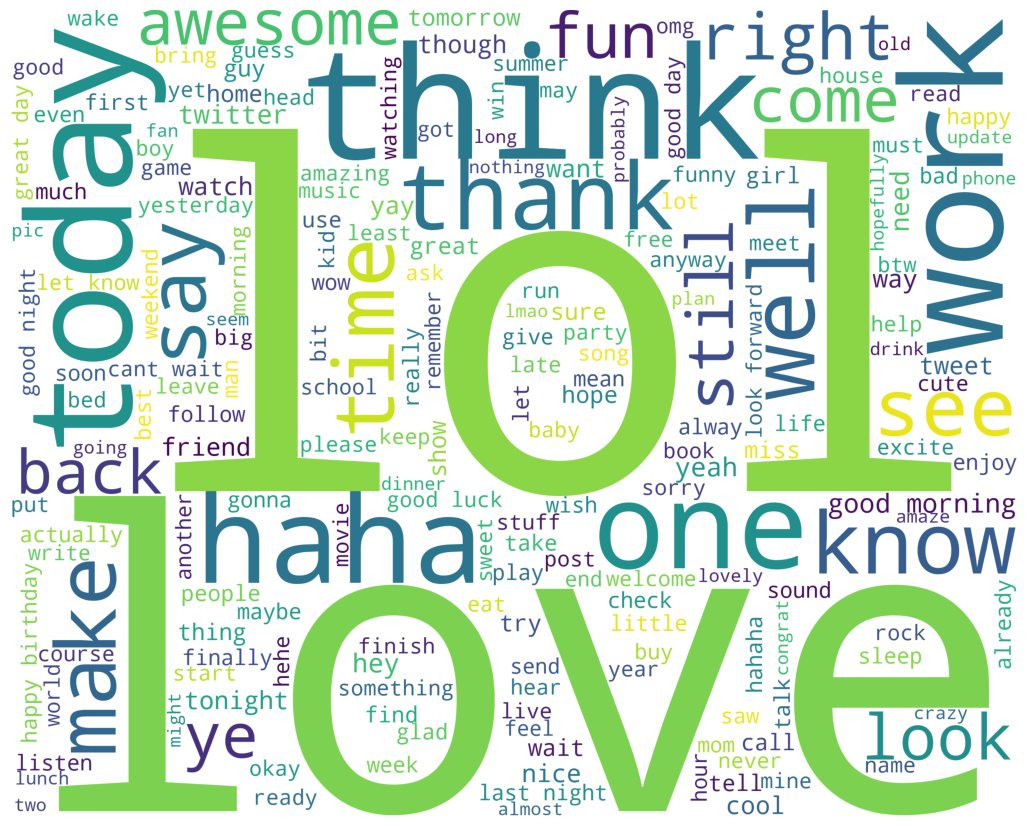

Negative words


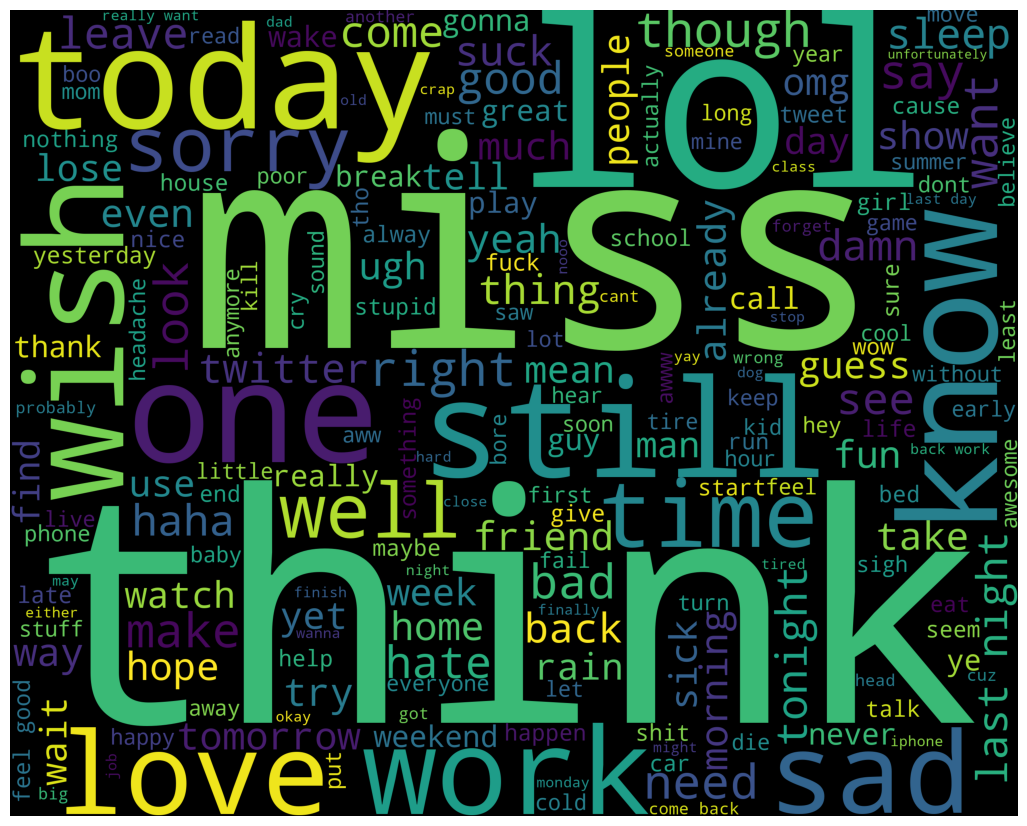

CPU Time: 48.47023296356201


In [17]:
from wordcloud import WordCloud, STOPWORDS

start_time = time()

positive_words = []
negative_words = []

# Separating out positive and negative words (i.e., words appearing in negative and positive tweets),
# in order to visualize each set of words independently
for i in range(len(cleaned_tokens_list)):
    if cleaned_tokens_list[i][1] == 1:
        positive_words.extend(cleaned_tokens_list[i][0])
    else:
        negative_words.extend(cleaned_tokens_list[i][0])

# Defining our word cloud drawing function
def wordcloud_draw(data, color = 'black'):
    wordcloud = WordCloud(stopwords = STOPWORDS,
                          background_color = color,
                          width = 2500,
                          height = 2000
                         ).generate(' '.join(data))
    plt.figure(1, figsize = (13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive words")
wordcloud_draw(positive_words, 'white')
print("Negative words")
wordcloud_draw(negative_words)        

print('CPU Time:', time() - start_time)

In [18]:
final_data[0:2]

[({'awww': True,
   "that's": True,
   'bummer': True,
   'shoulda': True,
   'get': True,
   'david': True,
   'carr': True,
   'third': True,
   'day': True},
  0),
 ({'upset': True,
   "can't": True,
   'update': True,
   'facebook': True,
   'texting': True,
   '...': True,
   'might': True,
   'cry': True,
   'result': True,
   'school': True,
   'today': True,
   'also': True,
   'blah': True},
  0)]

# Save Data

In [20]:
import pickle

with open('../NaiveBayes/input/train_data.pkl', 'wb') as file:
    pickle.dump(final_data, file)

# Load Data

In [26]:
# Load the training data from the file
with open('../NaiveBayes/input/train_data.pkl', 'rb') as file:
    loaded_train_data = pickle.load(file)


In [27]:
features = [item[0] for item in loaded_train_data]
labels = [item[1] for item in loaded_train_data]

In [28]:
from sklearn.model_selection import train_test_split
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

In [29]:
train_data = list(zip(X_train, y_train))
test_data = list(zip(X_test, y_test))

In [30]:
from nltk.classify import NaiveBayesClassifier
# Train the classifier
classifier = NaiveBayesClassifier.train(train_data)

In [33]:
from nltk.classify.util import accuracy

# Function to predict and calculate accuracy
def evaluate_classifier(classifier, train_data, test_data):
    # Predict on the training data
    train_accuracy = accuracy(classifier, train_data)
    print(f"Training Accuracy: {train_accuracy * 100:.4f}%")

    # Predict on the test data
    test_accuracy = accuracy(classifier, test_data)
    print(f"Test Accuracy: {test_accuracy * 100:.4f}%")

    return train_accuracy, test_accuracy


In [34]:
train_accuracy, test_accuracy = evaluate_classifier(classifier, train_data, test_data)


Training Accuracy: 79.7756%
Test Accuracy: 75.7578%
